# MLP 모델 성능 비교를 통한 하이퍼 파라미터 영향 평가

## 실험 준비

In [1]:
import os

import time

import copy

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "4"  # Set the GPU 3 to use

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [3]:
# 동일한 난수가 생성되도록 함

torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

### 베이스 모델의 하이퍼파라미터 설정

In [4]:
num_epochs = 50
learning_rate = 0.001

hidden_size = 256

batch_size = 512

### CIFAR-10 데이터셋 불러오기

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

input_size = 32 * 32 * 3
num_classes = 10

Files already downloaded and verified
Files already downloaded and verified


## MLP 모델 정의

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
model = MLP(input_size, hidden_size, num_classes)
model.to(device)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters.') # The model has 1,841,162 trainable parameters.

MLP(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 855,050 trainable parameters.


In [9]:
summary(model, input_size=(input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         786,688
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 256]          65,792
              ReLU-4                  [-1, 256]               0
            Linear-5                   [-1, 10]           2,570
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 3.26
Estimated Total Size (MB): 3.28
----------------------------------------------------------------


### 손실 함수 및 최적화 알고리즘 설정

In [10]:
criterion = nn.CrossEntropyLoss()

# 베이스 모델에서는 Adam Optimizer를 사용
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### plot 함수 정의

In [11]:
def loss_plot(title, train_loss_list, test_loss_list=[]):
    x = [i+1 for i in range(num_epochs)]

    # plt.style.use('ggplot')
    plt.figure(dpi=150)

    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')

    plt.plot(x, train_loss_list, label='train loss')
    if len(test_loss_list)>0:
        plt.plot(x, test_loss_list, label='test loss')

    plt.legend()
    plt.savefig(f"img/{title}.png")
    
    plt.title(title)
    plt.savefig(f"img/title/{title}.png")
    
    plt.show()

## (1) Wide VS. Narrow

In [13]:
history = []
hidden_size_list = [32, 64, 128, 256, 512, 1024, 2048]
for hidden_size in hidden_size_list:

    model = MLP(input_size, hidden_size, num_classes)
    model.to(device)
    print(model)
    print(f'The model has {count_parameters(model):,} trainable parameters when hidden_size is \"{hidden_size}\".')
    print(summary(model, input_size=(input_size,)))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    
    ## Main
    if __name__ == '__main__':
        train_loss_list = []

        # 학습 실행
        train_start_time = time.time()
        for epoch in range(num_epochs):
            # print(f"Epoch: [{epoch+1}/{num_epochs}],", end=" ")
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)

                # 입력 데이터를 1차원 벡터로 평탄화
                images = images.reshape(-1, input_size)

                # 모델의 예측값 계산
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)

                # 역전파 및 가중치 업데이트
                loss.backward()
                optimizer.step()

            train_loss = loss.item()
            train_loss_list.append(train_loss)
            # print(f"Train Loss: {train_loss:.4f}")

        m, s = divmod(time.time() - train_start_time, 60)
        print(f'Total Training Time : {m:.0f}m {s: .0f}s | Model was trained on {device}!')        

        # 모델 테스트
        with torch.no_grad():
            test_avg_loss = 0
            correct = 0
            total = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                # 입력 데이터를 1차원 벡터로 평탄화
                images = images.reshape(-1, input_size)

                # 모델의 예측값 계산
                output = model(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # loss 계산
                loss = criterion(output, labels)
                test_avg_loss += loss.item() / len(test_loader.dataset) 

            test_loss = test_avg_loss
            test_accuracy = 100 * correct / total
            print(f"Test Accuracy: {test_accuracy}%, Test Loss: {test_loss:.4f}")

        history.append((hidden_size, train_loss_list, test_accuracy, test_loss))            
        # loss_plot(f"Loss of MLP model by epoch when hidden_size is \"{hidden_size}\"", train_loss_list)

MLP(
  (fc1): Linear(in_features=3072, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 99,722 trainable parameters when hidden_size is "32".
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          98,336
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 10]             330
Total params: 99,722
Trainable params: 99,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
---------------------------

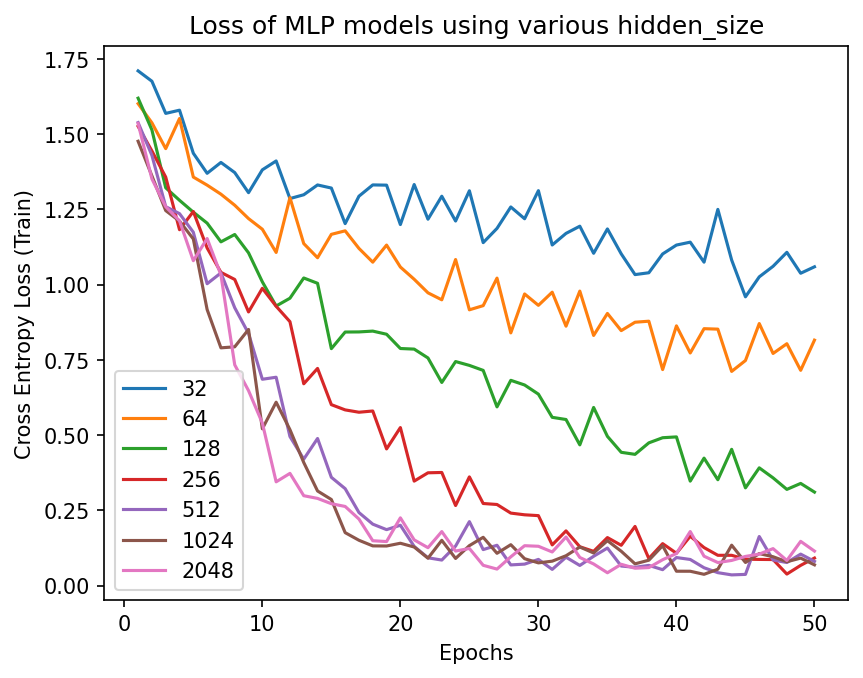

In [14]:
# plotting
x = [i+1 for i in range(num_epochs)]
plt.figure(dpi=150)

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss (Train)')

for idx in range(len(history)):
    label = history[idx][0]
    train_loss_list = history[idx][1]
    plt.plot(x, train_loss_list, label=f"{label}")

plt.legend()
title = "Loss of MLP models using various hidden_size"

plt.savefig(f"img/{title}.png")
plt.title(title)
plt.savefig(f"img/title/{title}.png")

plt.show()

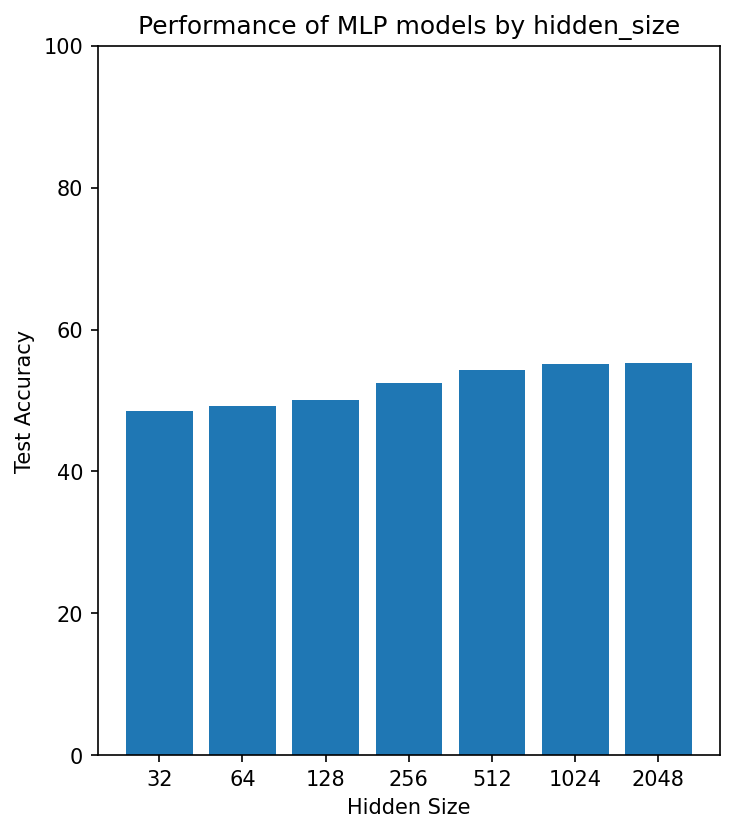

In [15]:
title = "Performance of MLP models by hidden_size"

test_accuracy_list = [history[i][2] for i in range(len(history))]
test_loss_list = [history[i][3] for i in range(len(history))]

plt.figure(dpi=150, figsize=(5, 5.5))
plt.bar([str(hid) for hid in hidden_size_list], test_accuracy_list)
plt.ylim([0, 100])
plt.ylabel('Test Accuracy')
plt.xlabel('Hidden Size')
plt.tight_layout()

plt.savefig(f"img/{title}.png")
plt.title(f'{title}')
plt.savefig(f"img/title/{title}.png")

plt.show()

In [16]:
accuray_list = [history[i][2] for i in range(len(history))]
best_idx = accuray_list.index(max(accuray_list))

best_hidden_size = history[best_idx][0]
hidden_size = best_hidden_size

best_history = []
best_history.append(history[best_idx])

## (2) Batch Normalization

In [17]:
class MLP_BN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP_BN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size) # 추가된 부분
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size) # 추가된 부분
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x) # 추가된 부분
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x) # 추가된 부분
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [18]:
model = MLP_BN(input_size, hidden_size, num_classes)
model.to(device)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters.') # The model has 1,841,162 trainable parameters.

MLP_BN(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 10,518,538 trainable parameters.


In [19]:
print(summary(model, input_size=(input_size,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            Linear-7                   [-1, 10]          20,490
Total params: 10,518,538
Trainable params: 10,518,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 40.13
Estimated Total Size (MB): 40.23
----------------------------------------------------------------
None


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            Linear-7                   [-1, 10]          20,490
Total params: 10,518,538
Trainable params: 10,518,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 40.13
Estimated Total Size (MB): 40.23
----------------------------------------------------------------
None
Total Training Time : 10m  5s | Model was trained on cuda!
Test Accuracy: 59.11%, Test Loss: 

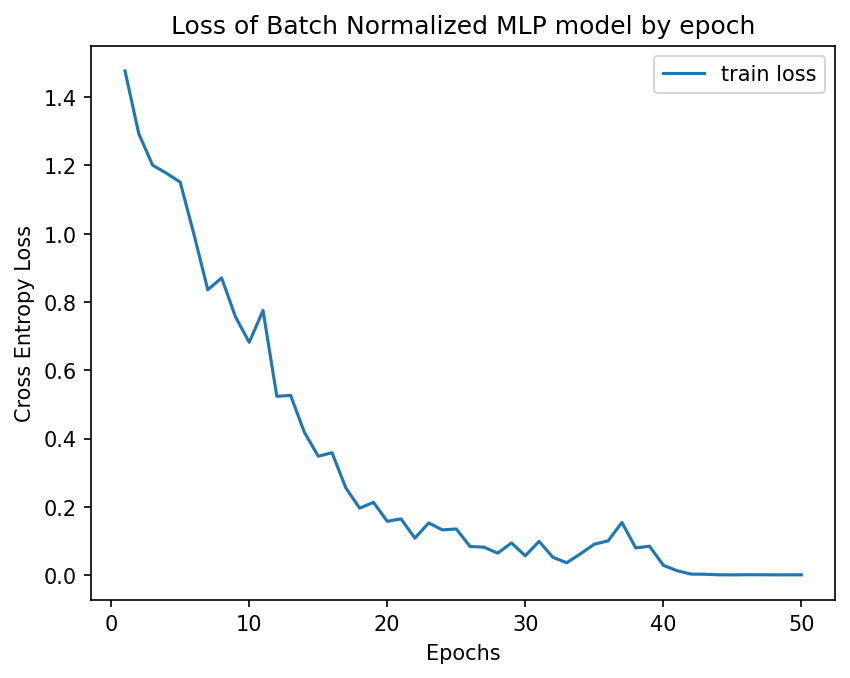

In [21]:
## Main
history = []

## Main
if __name__ == '__main__':
    train_loss_list = []
    print(summary(model, input_size=(input_size,)))

    # 학습 실행
    train_start_time = time.time()
    for epoch in range(num_epochs):
        # print(f"Epoch: [{epoch+1}/{num_epochs}],", end=" ")
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # 입력 데이터를 1차원 벡터로 평탄화
            images = images.reshape(-1, input_size)

            # 모델의 예측값 계산
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            # 역전파 및 가중치 업데이트
            loss.backward()
            optimizer.step()

        train_loss = loss.item()
        train_loss_list.append(train_loss)
        # print(f"Train Loss: {train_loss:.4f}")

    m, s = divmod(time.time() - train_start_time, 60)
    print(f'Total Training Time : {m:.0f}m {s: .0f}s | Model was trained on {device}!')        

    # 모델 테스트
    with torch.no_grad():
        test_avg_loss = 0
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # 입력 데이터를 1차원 벡터로 평탄화
            images = images.reshape(-1, input_size)

            # 모델의 예측값 계산
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss 계산
            loss = criterion(output, labels)
            test_avg_loss += loss.item() / len(test_loader.dataset) 

        test_loss = test_avg_loss
        test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {test_accuracy}%, Test Loss: {test_loss:.4f}")

    history.append((hidden_size, train_loss_list, test_accuracy, test_loss))            
    loss_plot(f"Loss of Batch Normalized MLP model by epoch", train_loss_list)

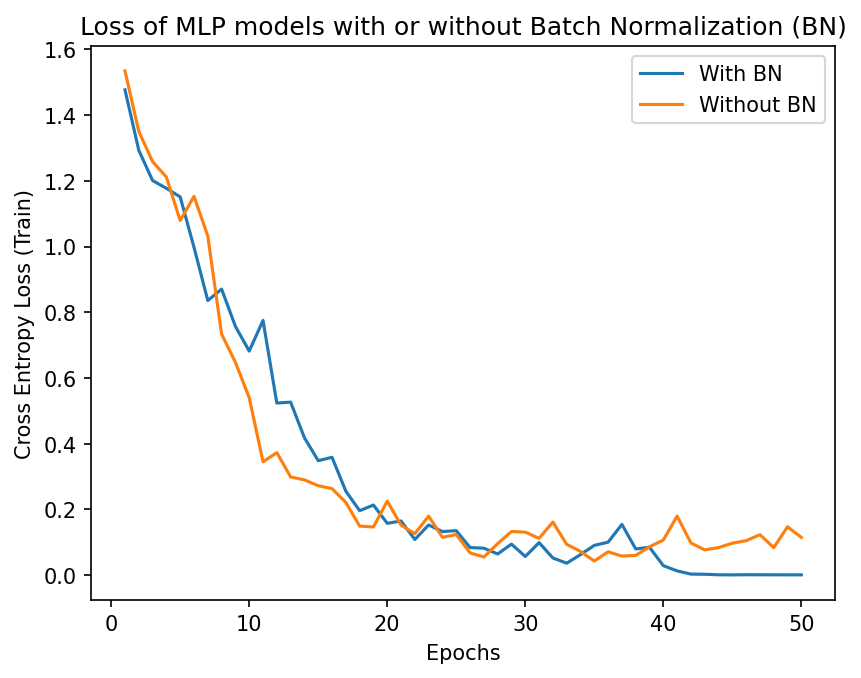

In [22]:
# plotting
x = [i+1 for i in range(num_epochs)]
plt.figure(dpi=150)

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss (Train)')

plt.plot(x, history[0][1], label="With BN")
plt.plot(x, best_history[0][1], label="Without BN")

plt.legend()

title = "Loss of MLP models with or without Batch Normalization (BN)"
plt.savefig(f"img/{title}.png")
plt.title(title)
plt.savefig(f"img/title/{title}.png")
plt.show()

In [23]:
best_history = history.copy()

## (3) learning rate
https://dacon.io/codeshare/2373

In [24]:
learning_rate_list = [0.1, 0.01, 0.001]

### Constant `learning_rate`s

In [25]:
history = []

for learning_rate in learning_rate_list:

    print(f"<MLP with learning_rate={learning_rate}>")
    
    model = MLP_BN(input_size, hidden_size, num_classes)
    model.to(device)
    print(model)
    print(f'The model has {count_parameters(model):,} trainable parameters.') # The model has 1,841,162 trainable parameters.
    print(summary(model, input_size=(input_size,)))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    lrs = []
    train_loss_list = []

    # 학습 실행
    train_start_time = time.time()
    for epoch in range(num_epochs):
        # print(f"Epoch: [{epoch+1}/{num_epochs}],", end=" ")
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # 입력 데이터를 1차원 벡터로 평탄화
            images = images.reshape(-1, input_size)

            # 모델의 예측값 계산
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)

            # 역전파 및 가중치 업데이트
            loss.backward()
            optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
            

        train_loss = loss.item()
        train_loss_list.append(train_loss)
        # print(f"Train Loss: {train_loss:.4f}")

    m, s = divmod(time.time() - train_start_time, 60)
    print(f'Total Training Time : {m:.0f}m {s: .0f}s | Model was trained on {device}!')        

    # 모델 테스트
    with torch.no_grad():
        test_avg_loss = 0
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # 입력 데이터를 1차원 벡터로 평탄화
            images = images.reshape(-1, input_size)

            # 모델의 예측값 계산
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss 계산
            loss = criterion(output, labels)
            test_avg_loss += loss.item() / len(test_loader.dataset) 

        test_loss = test_avg_loss
        test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {test_accuracy}%, Test Loss: {test_loss:.4f}")

    history.append((f"Constant ({str(learning_rate)})", train_loss_list, test_accuracy, test_loss, lrs))

<MLP with learning_rate=0.1>
MLP_BN(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 10,518,538 trainable parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            

### StepLR

In [26]:
print(f"<MLP with StepLR>")
    
model = MLP_BN(input_size, hidden_size, num_classes)
model.to(device)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters.') # The model has 1,841,162 trainable parameters.
print(summary(model, input_size=(input_size,)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

lrs = []
train_loss_list = []

# 학습 실행
train_start_time = time.time()
for epoch in range(num_epochs):
    # print(f"Epoch: [{epoch+1}/{num_epochs}],", end=" ")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
        

    train_loss = loss.item()
    train_loss_list.append(train_loss)
    # print(f"Train Loss: {train_loss:.4f}")

m, s = divmod(time.time() - train_start_time, 60)
print(f'Total Training Time : {m:.0f}m {s: .0f}s | Model was trained on {device}!')        

# 모델 테스트
with torch.no_grad():
    test_avg_loss = 0
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # loss 계산
        loss = criterion(output, labels)
        test_avg_loss += loss.item() / len(test_loader.dataset) 

    test_loss = test_avg_loss
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy}%, Test Loss: {test_loss:.4f}")

history.append(("StepLR", train_loss_list, test_accuracy, test_loss, lrs))

<MLP with StepLR>
MLP_BN(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 10,518,538 trainable parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            Linear-7   

### ExponentialLR

In [27]:
print(f"<MLP with ExponentialLR>")
    
model = MLP_BN(input_size, hidden_size, num_classes)
model.to(device)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters.') # The model has 1,841,162 trainable parameters.
print(summary(model, input_size=(input_size,)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

lrs = []
train_loss_list = []

# 학습 실행
train_start_time = time.time()
for epoch in range(num_epochs):
    # print(f"Epoch: [{epoch+1}/{num_epochs}],", end=" ")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
        

    train_loss = loss.item()
    train_loss_list.append(train_loss)
    # print(f"Train Loss: {train_loss:.4f}")

m, s = divmod(time.time() - train_start_time, 60)
print(f'Total Training Time : {m:.0f}m {s: .0f}s | Model was trained on {device}!')        

# 모델 테스트
with torch.no_grad():
    test_avg_loss = 0
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # loss 계산
        loss = criterion(output, labels)
        test_avg_loss += loss.item() / len(test_loader.dataset) 

    test_loss = test_avg_loss
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy}%, Test Loss: {test_loss:.4f}")

history.append(("ExponentialLR", train_loss_list, test_accuracy, test_loss, lrs))

<MLP with ExponentialLR>
MLP_BN(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 10,518,538 trainable parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            Line

### LambdaLR

In [28]:
print(f"<MLP with LambdaLR>")
    
model = MLP_BN(input_size, hidden_size, num_classes)
model.to(device)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters.') # The model has 1,841,162 trainable parameters.
print(summary(model, input_size=(input_size,)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1)

lambda1 = lambda epoch: 0.75 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

lrs = []
train_loss_list = []

# 학습 실행
train_start_time = time.time()
for epoch in range(num_epochs):
    # print(f"Epoch: [{epoch+1}/{num_epochs}],", end=" ")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
        

    train_loss = loss.item()
    train_loss_list.append(train_loss)
    # print(f"Train Loss: {train_loss:.4f}")

m, s = divmod(time.time() - train_start_time, 60)
print(f'Total Training Time : {m:.0f}m {s: .0f}s | Model was trained on {device}!')        

# 모델 테스트
with torch.no_grad():
    test_avg_loss = 0
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # loss 계산
        loss = criterion(output, labels)
        test_avg_loss += loss.item() / len(test_loader.dataset) 

    test_loss = test_avg_loss
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy}%, Test Loss: {test_loss:.4f}")

history.append(("LambdaLR", train_loss_list, test_accuracy, test_loss, lrs))

<MLP with LambdaLR>
MLP_BN(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 10,518,538 trainable parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            Linear-7 

### CosineAnnealingLR

In [29]:
print(f"<MLP with CosineAnnealingLR>")
    
model = MLP_BN(input_size, hidden_size, num_classes)
model.to(device)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters.') # The model has 1,841,162 trainable parameters.
print(summary(model, input_size=(input_size,)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
# T_max는 Cosine Annealing이 수행되는 최대 epoch 수이며, eta_min은 learning rate의 최소값을 나타냅니다.

lrs = []
train_loss_list = []

# 학습 실행
train_start_time = time.time()
for epoch in range(num_epochs):
    # print(f"Epoch: [{epoch+1}/{num_epochs}],", end=" ")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
        

    train_loss = loss.item()
    train_loss_list.append(train_loss)
    # print(f"Train Loss: {train_loss:.4f}")

m, s = divmod(time.time() - train_start_time, 60)
print(f'Total Training Time : {m:.0f}m {s: .0f}s | Model was trained on {device}!')        

# 모델 테스트
with torch.no_grad():
    test_avg_loss = 0
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # loss 계산
        loss = criterion(output, labels)
        test_avg_loss += loss.item() / len(test_loader.dataset) 

    test_loss = test_avg_loss
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy}%, Test Loss: {test_loss:.4f}")

history.append(("CosineAnnealingLR", train_loss_list, test_accuracy, test_loss, lrs))

<MLP with CosineAnnealingLR>
MLP_BN(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 10,518,538 trainable parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            

### CosineAnnealingWarmRestarts

In [30]:
print(f"<MLP with CosineAnnealingWarmRestarts>")
    
model = MLP_BN(input_size, hidden_size, num_classes)
model.to(device)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters.') # The model has 1,841,162 trainable parameters.
print(summary(model, input_size=(input_size,)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, T_mult=2, eta_min=0.0001)
# T_0: CosineAnnealingLR의 T_max와 같은 의미로, 첫 번째 사이클의 길이입니다.
# T_mult: 사이클 길이를 증가시키는 데 사용되는 스케일링 요소입니다.
# eta_min: learning rate가 cosine 함수의 최소값이 되는 값입니다.
# last_epoch: 마지막 epoch 번호를 나타내며, 스케줄러의 시작 epoch를 지정합니다.

lrs = []
train_loss_list = []

# 학습 실행
train_start_time = time.time()
for epoch in range(num_epochs):
    # print(f"Epoch: [{epoch+1}/{num_epochs}],", end=" ")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
        

    train_loss = loss.item()
    train_loss_list.append(train_loss)
    # print(f"Train Loss: {train_loss:.4f}")

m, s = divmod(time.time() - train_start_time, 60)
print(f'Total Training Time : {m:.0f}m {s: .0f}s | Model was trained on {device}!')        

# 모델 테스트
with torch.no_grad():
    test_avg_loss = 0
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # 입력 데이터를 1차원 벡터로 평탄화
        images = images.reshape(-1, input_size)

        # 모델의 예측값 계산
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # loss 계산
        loss = criterion(output, labels)
        test_avg_loss += loss.item() / len(test_loader.dataset) 

    test_loss = test_avg_loss
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy}%, Test Loss: {test_loss:.4f}")

history.append(("CosineAnnealingWarmRestarts", train_loss_list, test_accuracy, test_loss, lrs))

<MLP with CosineAnnealingWarmRestarts>
MLP_BN(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=10, bias=True)
  (relu): ReLU()
)
The model has 10,518,538 trainable parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
  

### Plot

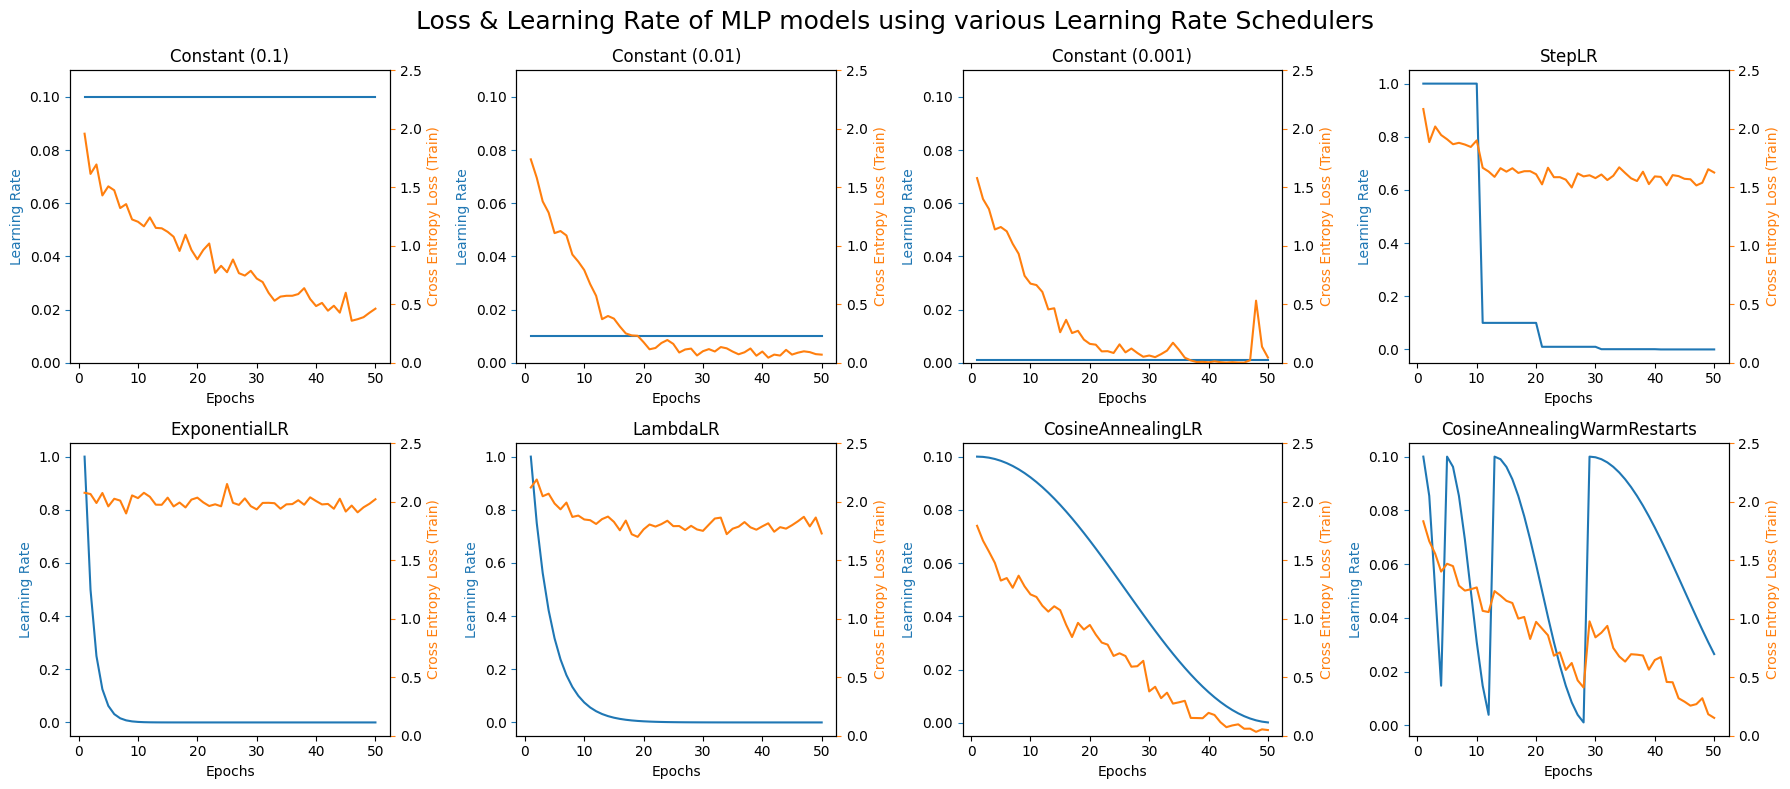

In [31]:
title = "Loss & Learning Rate of MLP models using various Learning Rate Schedulers"

# 2행 4열로 subplot 생성
fig, axs = plt.subplots(2, 4, figsize=(18, 8))

axs[0,0].set_ylim(0, 0.11)
axs[0,1].set_ylim(0, 0.11)
axs[0,2].set_ylim(0, 0.11)

for i in range(2):
    for j in range(4):
        idx = 4*i + j
        label = history[idx][0]
        train_loss_list = history[idx][1]
        learning_rate_list = history[idx][-1]
        
        axs[i, j].plot(range(1, num_epochs+1), learning_rate_list, color='C0')
        axs[i, j].set_title(label)
        axs[i, j].set_xlabel('Epochs')
        axs[i, j].set_ylabel('Learning Rate', color='C0')
        axs[i, j].tick_params(axis='y', color='C0')
        
        ax2 = axs[i, j].twinx()
        ax2.plot(range(1, num_epochs+1), train_loss_list, color='C1')
        ax2.set_ylabel('Cross Entropy Loss (Train)', color='C1')
        ax2.tick_params(axis='y', color='C1')
        ax2.set_ylim(0, 2.5)

plt.savefig(f"img/{title}.png")
fig.suptitle(title, fontsize=18)
plt.tight_layout()
plt.savefig(f"img/title/{title}.png")
plt.show()

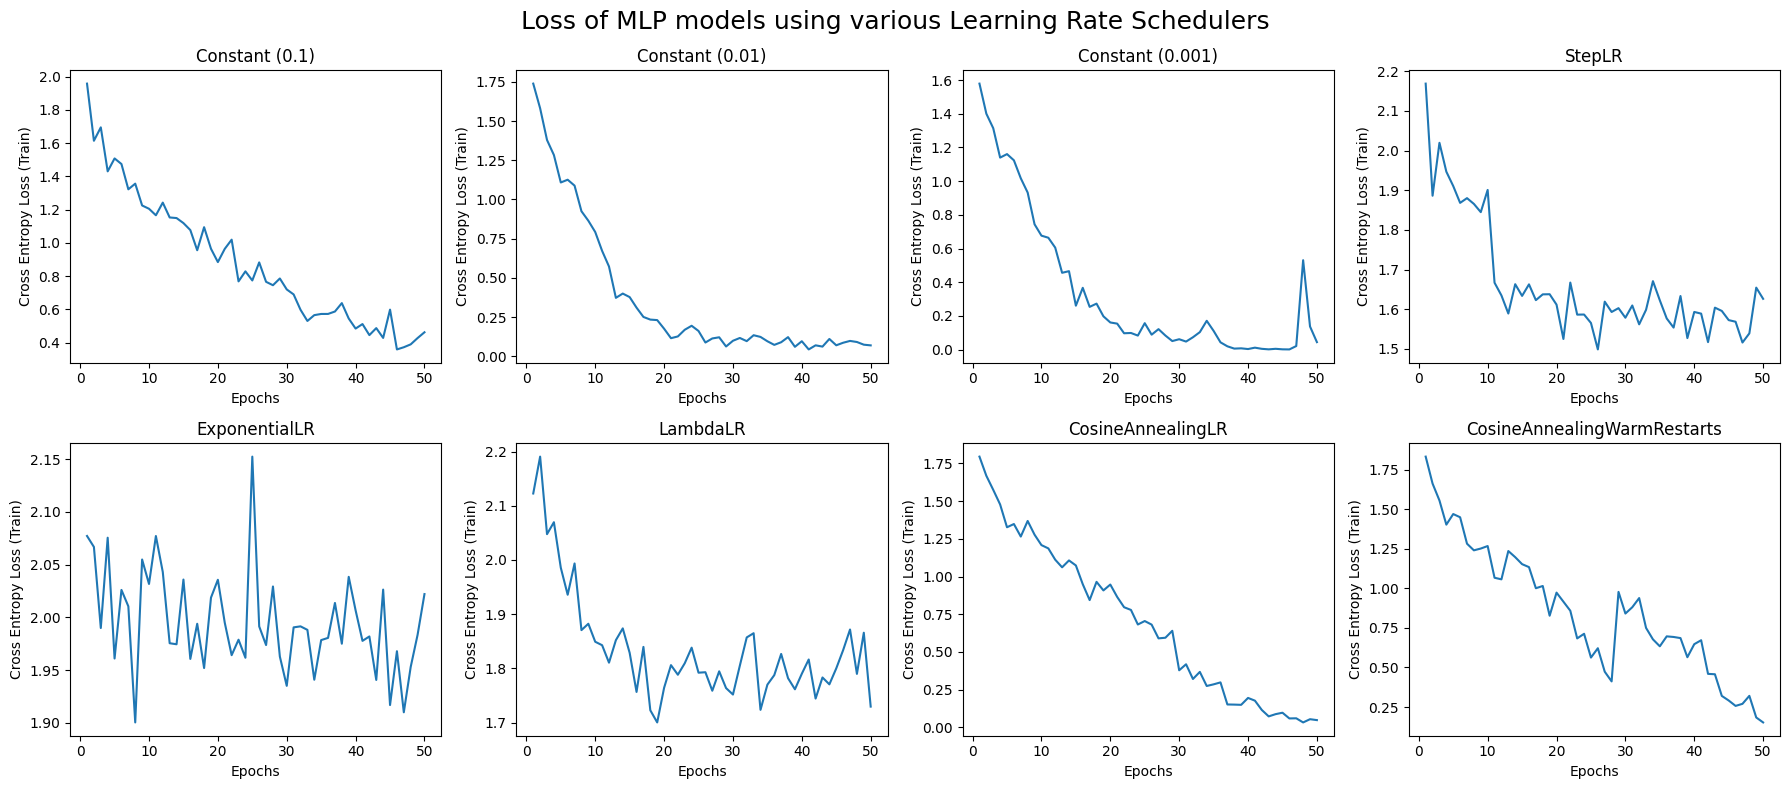

In [32]:
title = "Loss of MLP models using various Learning Rate Schedulers"

# 2행 4열로 subplot 생성
fig, axs = plt.subplots(2, 4, figsize=(18, 8))

for i in range(2):
    for j in range(4):
        idx = 4*i + j
        label = history[idx][0]
        train_loss_list = history[idx][1]
        
        axs[i, j].plot(range(1, num_epochs+1), train_loss_list)
        axs[i, j].set_title(label)
        axs[i, j].set_xlabel('Epochs')
        axs[i, j].set_ylabel('Cross Entropy Loss (Train)')

plt.savefig(f"img/{title}.png")
fig.suptitle(title, fontsize=18)
plt.tight_layout()
plt.savefig(f"img/title/{title}.png")
plt.show()

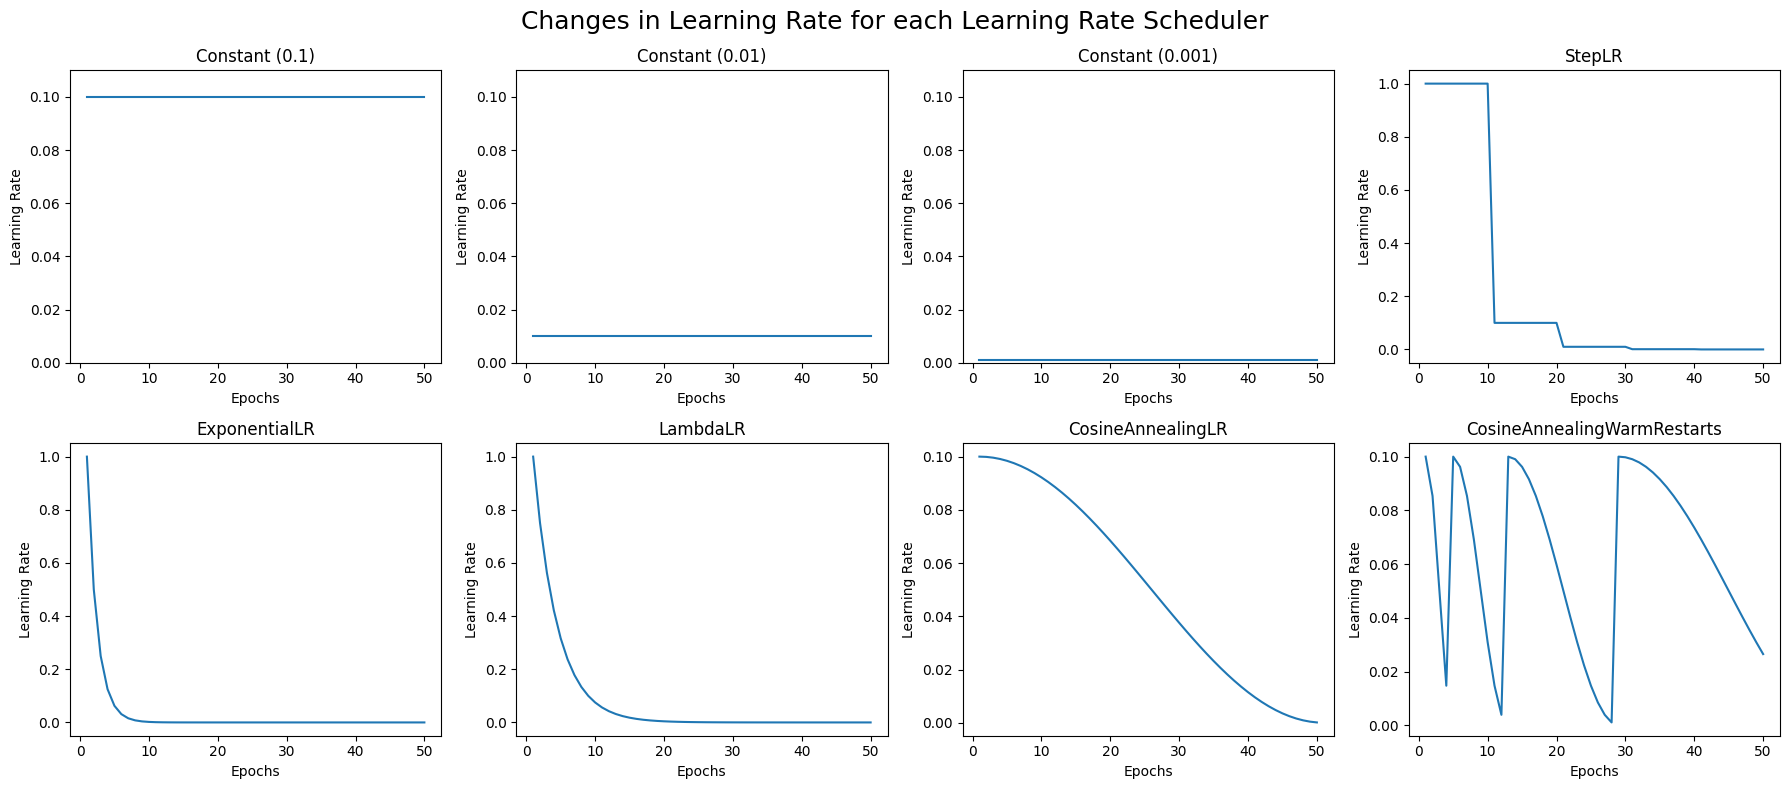

In [33]:
title = "Changes in Learning Rate for each Learning Rate Scheduler"

# 2행 4열로 subplot 생성
fig, axs = plt.subplots(2, 4, figsize=(18, 8))

axs[0,0].set_ylim(0, 0.11)
axs[0,1].set_ylim(0, 0.11)
axs[0,2].set_ylim(0, 0.11)

for i in range(2):
    for j in range(4):
        idx = 4*i + j
        label = history[idx][0]
        learning_rate_list = history[idx][-1]
        
        axs[i, j].plot(range(1, num_epochs+1), learning_rate_list)
        axs[i, j].set_title(label)
        axs[i, j].set_xlabel('Epochs')
        axs[i, j].set_ylabel('Learning Rate')
        
        
plt.savefig(f"img/{title}.png")
fig.suptitle(title, fontsize=18)
plt.tight_layout()
plt.savefig(f"img/title/{title}.png")
plt.show()

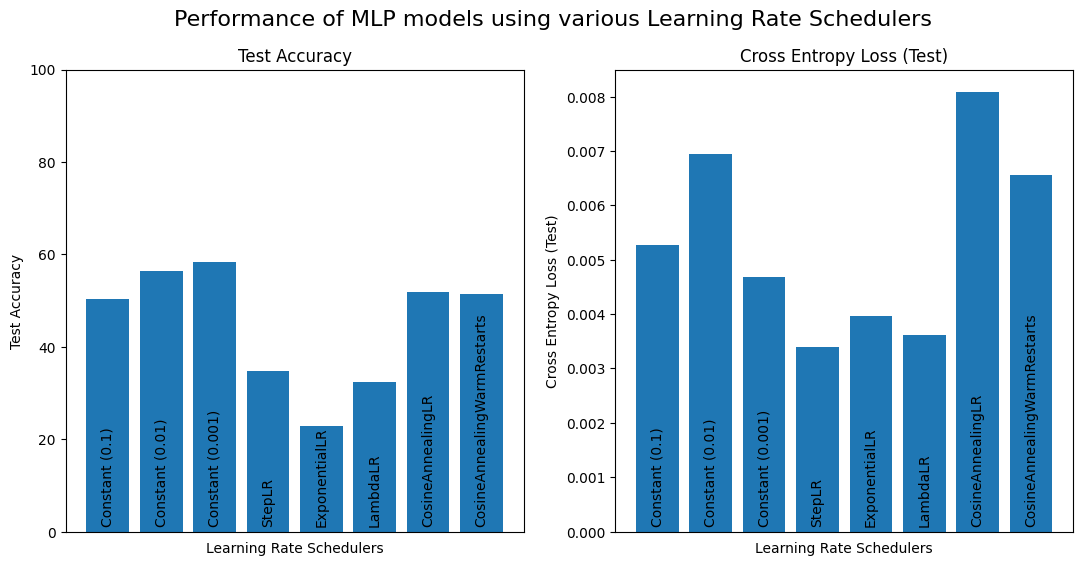

In [34]:
title = "Performance of MLP models using various Learning Rate Schedulers"

# 데이터
lr_name_list = [history[i][0] for i in range(len(history))]
test_accuracy_list = [history[i][2] for i in range(len(history))]
test_loss_list = [history[i][3] for i in range(len(history))]

# subplot으로 그래프 그리기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# 왼쪽 subplot: Test Accuracy 그래프
ax1.set_title('Test Accuracy')
ax1.bar(lr_name_list, test_accuracy_list)
ax1.set_ylim([0, 100])
ax1.set_ylabel('Test Accuracy')
for i, v in enumerate(lr_name_list):
    ax1.text(i, 1, str(v), ha='center', va='bottom', rotation=90)
ax1.get_xaxis().set_ticks([])
ax1.set_xlabel('Learning Rate Schedulers')

# 오른쪽 subplot: Test Loss 그래프
ax2.set_title('Cross Entropy Loss (Test)')
ax2.bar(lr_name_list, test_loss_list)
ax2.set_ylabel('Cross Entropy Loss (Test)')
for i, v in enumerate(lr_name_list):
    ax2.text(i, 0.0001, str(v), ha='center', va='bottom', rotation=90)
ax2.get_xaxis().set_ticks([])
ax2.set_xlabel('Learning Rate Schedulers')

# 전체 그래프 제목
plt.savefig(f"img/{title}.png")
fig.suptitle(title, fontsize=16)
plt.savefig(f"img/title/{title}.png")
plt.show()

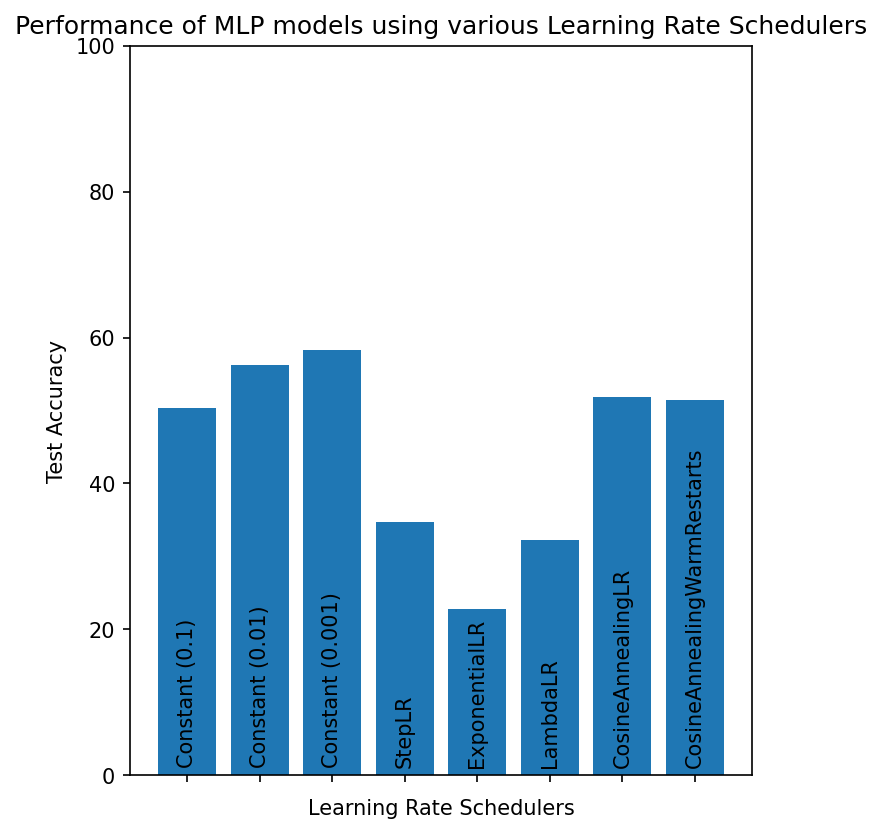

In [35]:
title = "Performance of MLP models using various Learning Rate Schedulers"

# 데이터
lr_name_list = [history[i][0] for i in range(len(history))]
test_accuracy_list = [history[i][2] for i in range(len(history))]
test_loss_list = [history[i][3] for i in range(len(history))]

# subplot으로 그래프 그리기
plt.figure(dpi=150, figsize=(5, 5.5))
# 왼쪽 subplot: Test Accuracy 그래프
plt.bar(lr_name_list, test_accuracy_list)
plt.ylim([0, 100])
plt.ylabel('Test Accuracy')
for i, v in enumerate(lr_name_list):
    plt.text(i, 1, str(v), ha='center', va='bottom', rotation=90)
ax = plt.gca()

ax.axes.xaxis.set_ticklabels([])
plt.xlabel('Learning Rate Schedulers')
plt.tight_layout()

plt.savefig(f"img/{title}.png")
plt.title(f'{title}')
plt.savefig(f"img/title/{title}.png")

plt.show()

Files already downloaded and verified


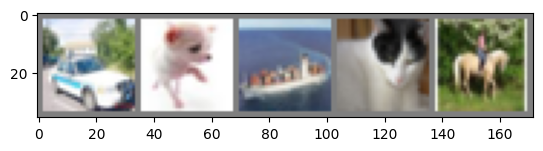

car   dog   ship  cat   horse


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))